In [5]:
import copy
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
data_dir = 'cats-or-dogs'

In [3]:
# Data preparation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [7]:
# Use clip as a pre-trained model for embeddings
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

C:\Users\bemil\AppData\Roaming\Python\Python37\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\bemil\AppData\Roaming\Python\Python37\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\bemil/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [8]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

In [9]:
# Training a classifier
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_model_wts)
    return model

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = model.to(device)

In [11]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

train Loss: 0.5693 Acc: 0.6900
test Loss: 0.1713 Acc: 0.9500
train Loss: 0.4358 Acc: 0.7850
test Loss: 0.1981 Acc: 0.9750
train Loss: 0.5411 Acc: 0.7500
test Loss: 0.1388 Acc: 0.9250
train Loss: 0.5121 Acc: 0.7800
test Loss: 0.1133 Acc: 0.9500
train Loss: 0.4133 Acc: 0.8150
test Loss: 0.1912 Acc: 0.9750
train Loss: 0.4875 Acc: 0.8000
test Loss: 0.1082 Acc: 0.9750
train Loss: 0.3253 Acc: 0.8550
test Loss: 0.1233 Acc: 0.9750
train Loss: 0.3015 Acc: 0.8650
test Loss: 0.0875 Acc: 0.9500
train Loss: 0.3640 Acc: 0.8200
test Loss: 0.0919 Acc: 0.9500
train Loss: 0.3453 Acc: 0.8400
test Loss: 0.0933 Acc: 0.9500
train Loss: 0.3710 Acc: 0.8300
test Loss: 0.0956 Acc: 0.9500
train Loss: 0.3476 Acc: 0.8400
test Loss: 0.1212 Acc: 0.9250
train Loss: 0.3584 Acc: 0.8500
test Loss: 0.0790 Acc: 0.9500
train Loss: 0.2842 Acc: 0.8800
test Loss: 0.0983 Acc: 0.9750
train Loss: 0.3020 Acc: 0.8800
test Loss: 0.1103 Acc: 0.9500
train Loss: 0.2870 Acc: 0.8650
test Loss: 0.0866 Acc: 0.9500
train Loss: 0.2704 Acc: 

In [12]:
# Testing accuracy
correct = 0
total = 0
predicted_labels = []
true_labels = []
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted)
        true_labels.extend(labels)

print('Accuracy of the network on the 100 test images: %d %%' % (100 * correct / total))



Accuracy of the network on the 100 test images: 97 %


Confusion matrix, without normalization


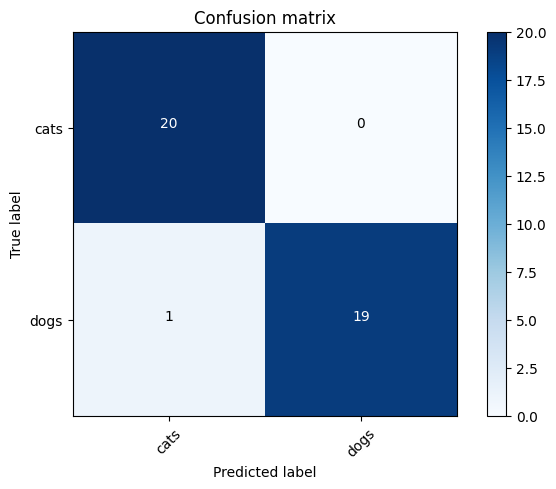

In [13]:
# Show confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(true_labels, predicted_labels)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')